#Desarrollo y Evaluación Comparativa de Modelos de Aprendizaje Automático para la Clasificación de Osteoartritis de Rodilla a partir de Señales Vibroartrográficas.

## 1. Análisis Exploratorio y Preparación del Entorno

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA


In [31]:
import pandas as pd
import numpy as np

def preparar_dataset_estricto(ruta_sano_train, ruta_enfermo_train, ruta_enfermo_test_nuevo):
    
    # Definimos las columnas FINALES que usaremos (Ya no está peak_freq)
    features_finales = ['rms_amp', 'spectral_entropy', 'zcr', 'mean_freq']
    
    def procesar_filas_fusionadas(ruta, etiqueta_target, etiqueta_partition):
        df = pd.read_csv(ruta)
        data = []
        
        for _, row in df.iterrows():
            # --- LÓGICA DE FUSIÓN (L vs R) ---
            
            # 1. RMS Amplitude: Nos quedamos con la MAYOR (Más energía = Más probable daño)
            rms = max(row['rms_amp_L'], row['rms_amp_R'])
            
            # 2. Spectral Entropy: Nos quedamos con la MENOR (Condición especial que pediste)
            entropy = min(row['spectral_entropy_L'], row['spectral_entropy_R'])
            
            # 3. Zero Crossing Rate: Nos quedamos con la MAYOR
            zcr = max(row['zcr_L'], row['zcr_R'])
            
            # 4. Mean Frequency: Nos quedamos con la MAYOR
            mean_f = max(row['mean_freq_L'], row['mean_freq_R'])
            
            # NOTA: Peak Frequency ha sido DESCARTADO deliberadamente.
            
            # Construimos la fila única para este sujeto
            row_data = [rms, entropy, zcr, mean_f, etiqueta_target, etiqueta_partition]
            data.append(row_data)
            
        return data

    # 1. Cargar y Procesar TRAIN (Sanos + Enfermos Viejos)
    data_sano = procesar_filas_fusionadas(ruta_sano_train, 0, 'train')         
    data_enfermo = procesar_filas_fusionadas(ruta_enfermo_train, 1, 'train')   

    # 2. Cargar y Procesar TEST (SOLO Enfermos Nuevos)
    data_test_nuevo = procesar_filas_fusionadas(ruta_enfermo_test_nuevo, 1, 'test') 

    # 3. Unir todo en un solo DataFrame
    cols_finales = features_finales + ['target', 'partition']
    data_total = data_sano + data_enfermo + data_test_nuevo
    
    df_final = pd.DataFrame(data_total, columns=cols_finales)
    
    # Mezclamos aleatoriamente
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_final

In [32]:
# RUTAS DE ARCHIVOS (Ajusta el nombre del tercer archivo)
archivo_sano = 'Data/cheby2/features_cheby2_sano.csv'
archivo_enfermo_train = 'Data/cheby2/features_cheby23_diagnosticado.csv'
archivo_enfermo_test = 'Data/cheby2/features_cheby2_diagnosticado.csv' 

# Generamos el dataset maestro con etiquetas internas
df_dataset = preparar_dataset_estricto(archivo_sano, archivo_enfermo_train, archivo_enfermo_test)

print(f"--- Data Cargada con Separación Estricta ---")
print(f"Total de muestras: {len(df_dataset)}")
print(f"Muestras para Training: {len(df_dataset[df_dataset['partition']=='train'])}")
print(f"Muestras para Testing: {len(df_dataset[df_dataset['partition']=='test'])}")
print(f"Distribución de clases:\n{df_dataset['target'].value_counts()}")

# Visualizar
df_dataset.head()

--- Data Cargada con Separación Estricta ---
Total de muestras: 168
Muestras para Training: 127
Muestras para Testing: 41
Distribución de clases:
target
1    108
0     60
Name: count, dtype: int64


,rms_amp,spectral_entropy,zcr,mean_freq,target,partition
0,0.003215,10.319609,32068.209877,16024.290204,1,test
1,0.002687,10.303114,32008.351293,16014.902811,0,train
2,0.013661,10.216206,32032.797030,16040.430425,1,train
3,0.005996,9.945476,32007.711039,16025.446758,0,train
4,0.008528,10.331343,32041.427400,16023.247034,1,test


Verificamos si las características distinguen bien las clases antes de entrenar.

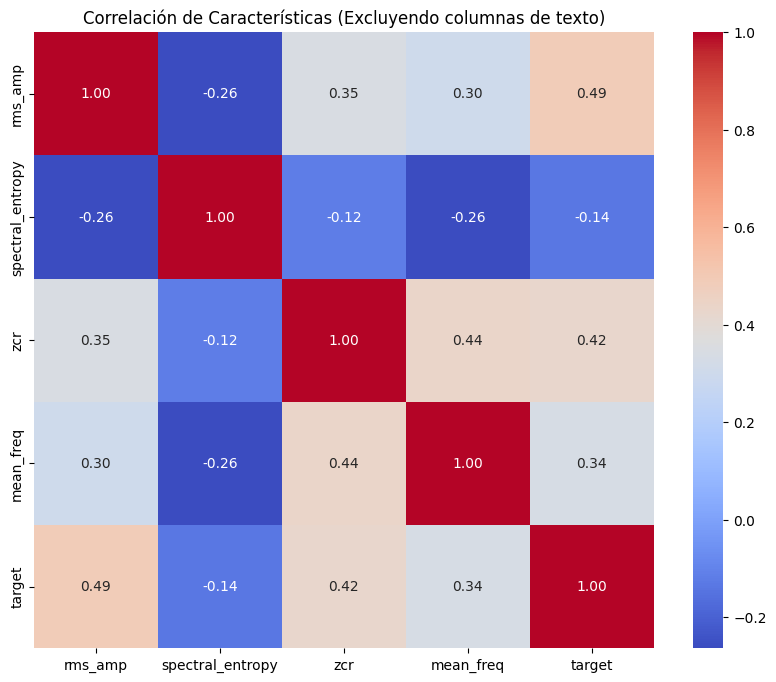

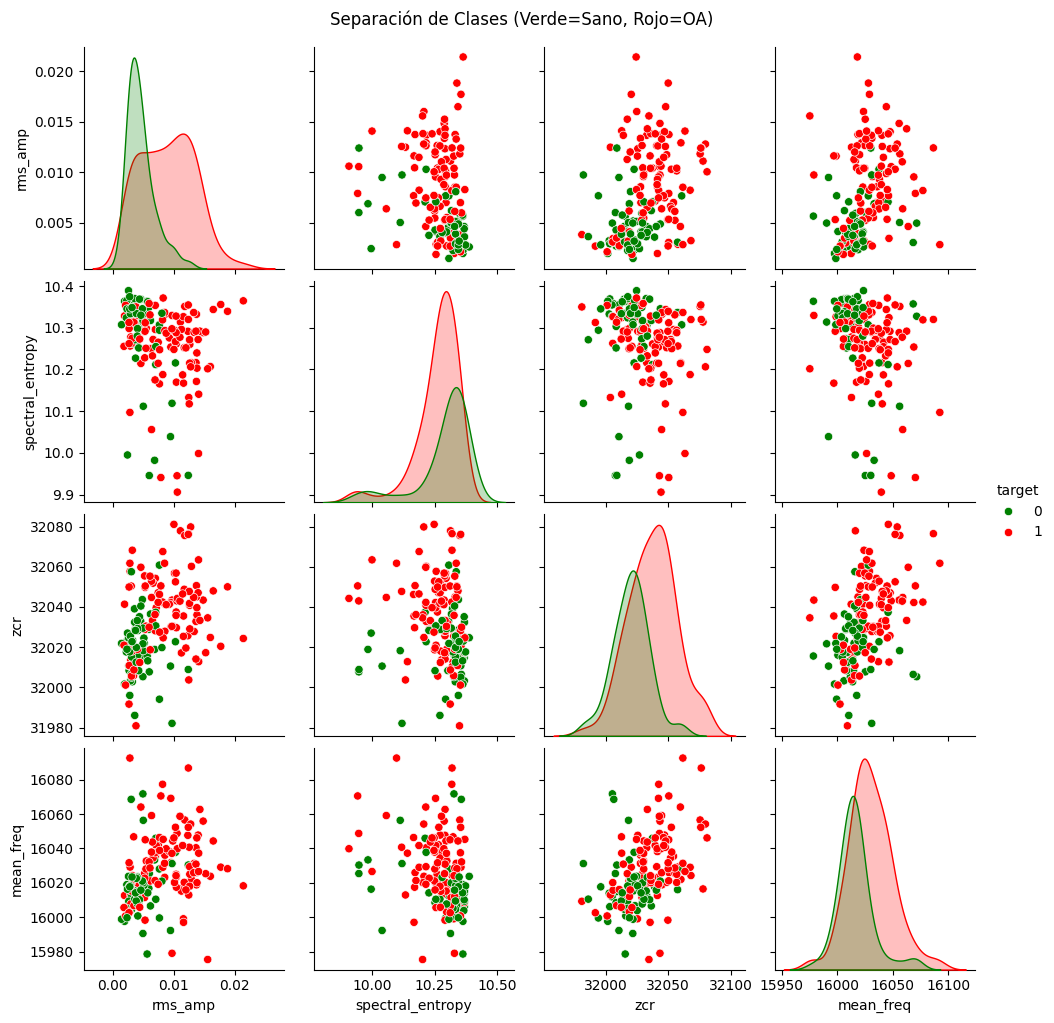

In [33]:
import numpy as np # Asegúrate de importar numpy si no lo has hecho

# 1. Mapa de calor de correlación
plt.figure(figsize=(10, 8))

# --- CORRECCIÓN ---
# Excluimos la columna 'partition' (que es texto) usando numeric_only=True
# o seleccionando solo tipos numéricos.
corr_matrix = df_dataset.select_dtypes(include=[np.number]).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación de Características (Excluyendo columnas de texto)")
plt.show()

# 2. Pairplot para ver separación de clases
# También quitamos 'partition' aquí para que el gráfico salga limpio
cols_to_plot = df_dataset.columns.drop('partition')

sns.pairplot(df_dataset[cols_to_plot], hue='target', palette={0: 'green', 1: 'red'})
plt.suptitle("Separación de Clases (Verde=Sano, Rojo=OA)", y=1.02)
plt.show()

Balance de Clases: Se observa que el conjunto de datos está razonablemente balanceado. Esto es crucial, ya que un desbalance severo podría sesgar el entrenamiento del modelo y hacer que métricas como la exactitud (Accuracy) sean engañosas[1]. Al estar balanceado, la exactitud sigue siendo una métrica relevante, aunque no la única.

Escala de Características: El resumen estadístico de .describe() muestra que las características (rms_amplitude, spectral_entropy, etc.) operan en rangos y escalas muy diferentes. Por ejemplo, spectral_entropy tiene valores negativos en el orden de miles, mientras que zero_crossing_rate es cercano a cero. Esta disparidad hace que el escalado de características sea un paso de preprocesamiento indispensable.

## 2. Ingeniería de Características (Feature Engineering)
Se realizó ingeniería de características generando indicadores sintéticos como el 'ratio_rms_freq' para capturar la relación no lineal entre la energía del chasquido y su frecuencia dominante.[2].

2.1 Generación de Nuevas Características (Feature Extraction)
Nuevas variables creadas. Total de columnas: 8

2.2 Ranking de Importancia (Random Forest) - Solo Datos de Entrenamiento


C:\Users\GIORDANO\AppData\Local\Temp\ipykernel_17196\3723605051.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=importancia, palette='viridis')


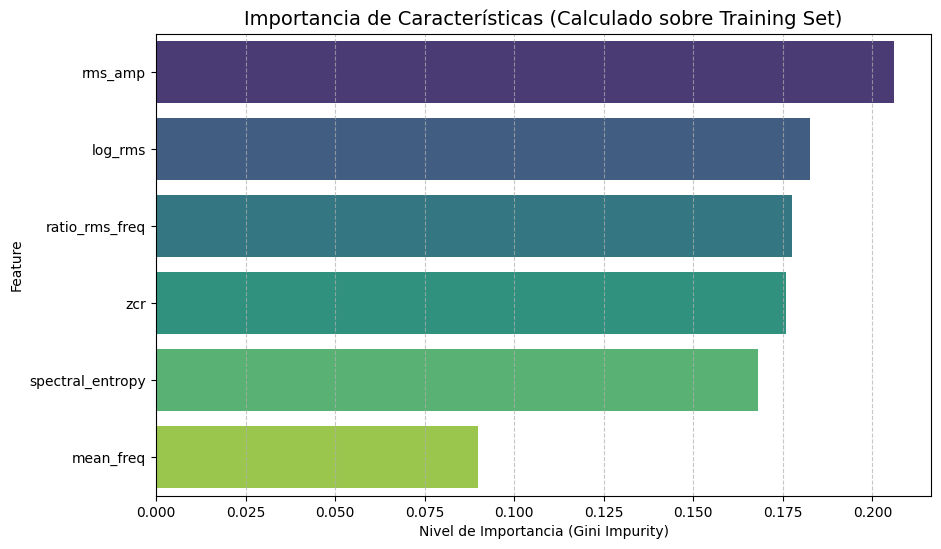

Top 3 Características más discriminantes:
          Feature  Importancia
0         rms_amp     0.206084
5         log_rms     0.182500
4  ratio_rms_freq     0.177548

--- 2.3 Análisis de Componentes Principales (PCA) ---


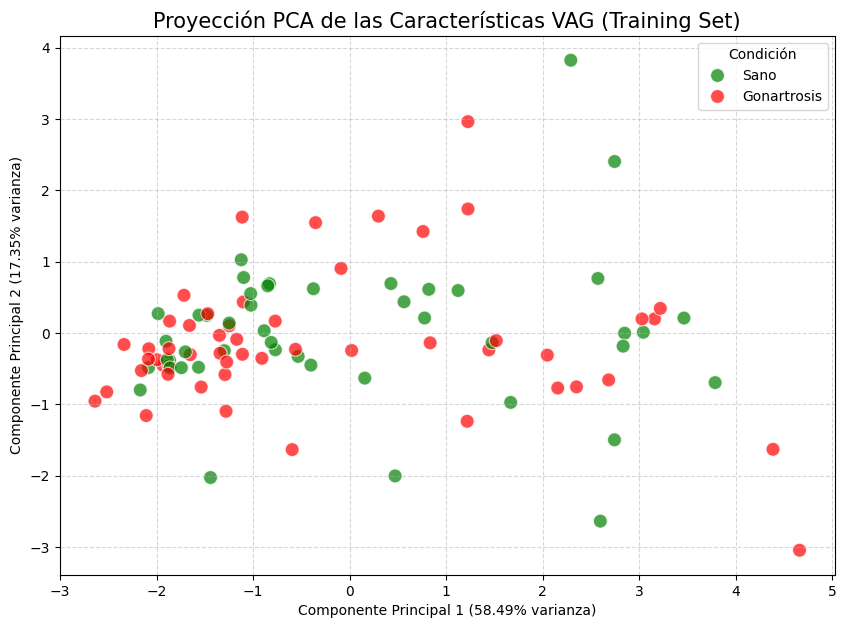

In [34]:
# BLOQUE 4: INGENIERÍA Y SELECCIÓN DE CARACTERÍSTICAS (CORREGIDO)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("2.1 Generación de Nuevas Características (Feature Extraction)")

# 1. Crear Meta-Features (Esto se aplica a TODO el dataset, train y test)
# Ratio Energía/Frecuencia
df_dataset['ratio_rms_freq'] = df_dataset['rms_amp'] / (df_dataset['mean_freq'] + 1e-6)


# Factor de Cresta Aproximado (Logarítmico)
df_dataset['log_rms'] = np.log1p(df_dataset['rms_amp'])

print(f"Nuevas variables creadas. Total de columnas: {df_dataset.shape[1]}")
df_dataset.head()

# 2.2 ANÁLISIS DE IMPORTANCIA (Usando SOLO datos de TRAIN para evitar Data Leakage)
print("\n2.2 Ranking de Importancia (Random Forest) - Solo Datos de Entrenamiento")

# Filtramos solo las filas que son de entrenamiento
df_analysis = df_dataset[df_dataset['partition'] == 'train'].copy()

# Definimos X_eng eliminando 'target' Y TAMBIÉN 'partition'
X_eng = df_analysis.drop(['target', 'partition'], axis=1)
y_eng = df_analysis['target']

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_eng, y_eng)

# Crear DataFrame de importancia
importancia = pd.DataFrame({
    'Feature': X_eng.columns,
    'Importancia': rf_selector.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Gráfica de Importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancia, palette='viridis')
plt.title('Importancia de Características (Calculado sobre Training Set)', fontsize=14)
plt.xlabel('Nivel de Importancia (Gini Impurity)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Top 3 Características más discriminantes:")
print(importancia.head(3))

# 2.3 VISUALIZACIÓN DE SEPARABILIDAD (PCA 2D)
print("\n--- 2.3 Análisis de Componentes Principales (PCA) ---")

# 1. Estandarizar (Crucial para PCA)
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_eng)

# 2. Aplicar PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_pca_scaled)

# 3. Crear DataFrame para graficar
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
df_pca['Diagnóstico'] = y_eng.map({0: 'Sano', 1: 'Gonartrosis'})
# Reiniciamos el índice de y_eng para que coincida con el dataframe nuevo df_pca
df_pca['Diagnóstico'] = df_pca['Diagnóstico'].reset_index(drop=True)

# 4. Graficar
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Diagnóstico', 
    palette={'Sano': 'green', 'Gonartrosis': 'red'},
    data=df_pca, 
    alpha=0.7, 
    s=100
)
plt.title('Proyección PCA de las Características VAG (Training Set)', fontsize=15)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.legend(title='Condición')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Pasamos de 4 características originales a 7.

Las nuevas características incluyen las originales, utilizando operaciones matematicas entre ellos. Esto puede permitir a los modelo capturar relaciones más complejas.

## 2.2. Codificación, División y Escalado de Datos
La codificación de etiquetas (LabelEncoder) es un paso esencial, ya que los algoritmos de Scikit-learn requieren que la variable objetivo sea numérica, y en este sentido LabelEncoder transforma las etiquetas categóricas (como 'normal' u 'osteoarthritis') a un formato numérico (0, 1). Posteriormente, se aplica la división estratificada (train_test_split), que constituye un pilar en la validación de modelos, pues divide el dataset para entrenar el modelo en un subconjunto de datos y luego evaluar su rendimiento en otro subconjunto nunca antes visto (el de prueba). Esto proporciona una estimación insesgada de cómo se comportará el modelo en datos futuros y, además, al utilizar el parámetro stratify=y se asegura que la proporción de clases sea la misma en los conjuntos de entrenamiento y prueba, lo cual resulta vital especialmente en datasets pequeños o desbalanceados [3]. Finalmente, se incorpora el escalado de características (StandardScaler), ya que, como se observó en el EDA, las características presentan escalas dispares; en consecuencia, algoritmos como SVM (que calcula distancias para definir el hiperplano), KNN (basado en distancias de vecindad) y Redes Neuronales (cuyos pesos se actualizan mediante descenso de gradiente) son particularmente sensibles a la escala. StandardScaler transforma los datos para que tengan una media de 0 y una desviación estándar de 1, lo cual asegura que todas las características contribuyan por igual al entrenamiento y evita que aquellas con magnitudes mayores dominen el proceso de aprendizaje[4]

In [35]:
# 2.2 CODIFICACIÓN, DIVISIÓN Y ESCALADO DE DATOS (ESTRICTO)
from sklearn.preprocessing import StandardScaler

# 1. Separar usando la columna 'partition' que creamos en el Bloque 1
print("--- Separando Datos según Archivos Originales ---")

# Filtros
mask_train = df_dataset['partition'] == 'train'
mask_test = df_dataset['partition'] == 'test'

# Definir X (Variables) y y (Target)
# IMPORTANTE: Eliminamos 'target' Y TAMBIÉN 'partition' de las variables predictoras
features_cols = df_dataset.columns.drop(['target', 'partition'])

X_train = df_dataset.loc[mask_train, features_cols]
y_train = df_dataset.loc[mask_train, 'target']

X_test = df_dataset.loc[mask_test, features_cols]
y_test = df_dataset.loc[mask_test, 'target']

print(f"Dimensiones Training: {X_train.shape}")
print(f"Dimensiones Testing:  {X_test.shape}")



# 3. Escalado de Datos
scaler = StandardScaler()

# Aprendemos la escala SOLO del Training (Sanos + Enfermos viejos)
X_train_scaled = scaler.fit_transform(X_train)

# Aplicamos esa escala al Testing (Enfermos nuevos)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame (estética)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_cols)

print("\n--- Escalado completado ---")
print("Media Train (debe ser ~0):", X_train_scaled.iloc[:, 0].mean())
print("Media Test (puede no ser 0):", X_test_scaled.iloc[:, 0].mean())


--- Separando Datos según Archivos Originales ---
Dimensiones Training: (127, 6)
Dimensiones Testing:  (41, 6)

--- Escalado completado ---
Media Train (debe ser ~0): 1.9232209875396412e-17
Media Test (puede no ser 0): 0.4475303784816947


## 3. Metodología de Modelado y Justificación de Hiperparámetros
Para garantizar una comparación justa y robusta entre los algoritmos de clasificación, cada modelo será sometido a un proceso de optimización de hiperparámetros utilizando una búsqueda en parrilla con validación cruzada de 5 pliegues (GridSearchCV). Este método asegura que los parámetros seleccionados no solo funcionen bien en una división particular de los datos, sino que generalicen adecuadamente.

Dada la prioridad clínica de detectar la mayor cantidad posible de casos de osteoartritis, la métrica de optimización principal para la búsqueda será el recall y el f1-score. Adicionalmente, se analizará el tiempo de ajuste (mean_fit_time) para evaluar la eficiencia computacional de las configuraciones más prometedoras.

### 3.1. Support Vector Machine (SVM)
SVM busca el hiperplano que mejor separa las clases en el espacio de características. Su fortaleza reside en el "truco del kernel" (kernel trick), que le permite operar en un espacio de características de alta dimensión sin un alto costo computacional.

El kernel define la transformación del espacio de características. Los más comunes son:

Lineal: Rápido, pero solo útil para datos linealmente separables.

Polinómico: Modela relaciones no lineales, pero es sensible a los hiperparámetros de grado y C.

RBF (Función de Base Radial): Es un kernel muy flexible y potente, capaz de modelar relaciones extremadamente complejas. Funciona como un kernel de dimensión infinita. Suele ser la primera opción cuando no se tiene conocimiento previo sobre la linealidad de los datos[5].

### 3.1.1 Prueba Empírica para la Selección del Kernel:

Iniciando optimización exhaustiva para SVM
Optimización completada en 0.52 segundos.
--------------------------------------------------
--- DESGLOSE DEL MEJOR RENDIMIENTO POR MÉTRICA ---
Mejor Recall:    0.6440 | Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor F1-Score:  0.7481 | Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor Accuracy:  0.7806 | Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
------------------------------------------------------------


C:\Users\GIORDANO\AppData\Local\Temp\ipykernel_17196\3617457004.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=best_per_kernel.index, y=best_per_kernel.values, palette='viridis')


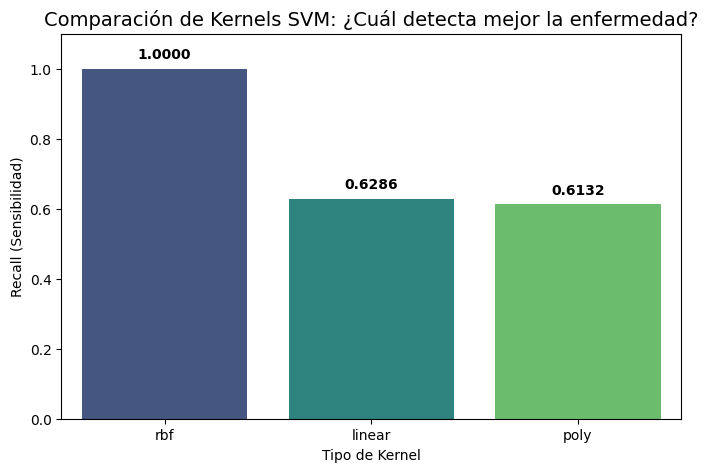

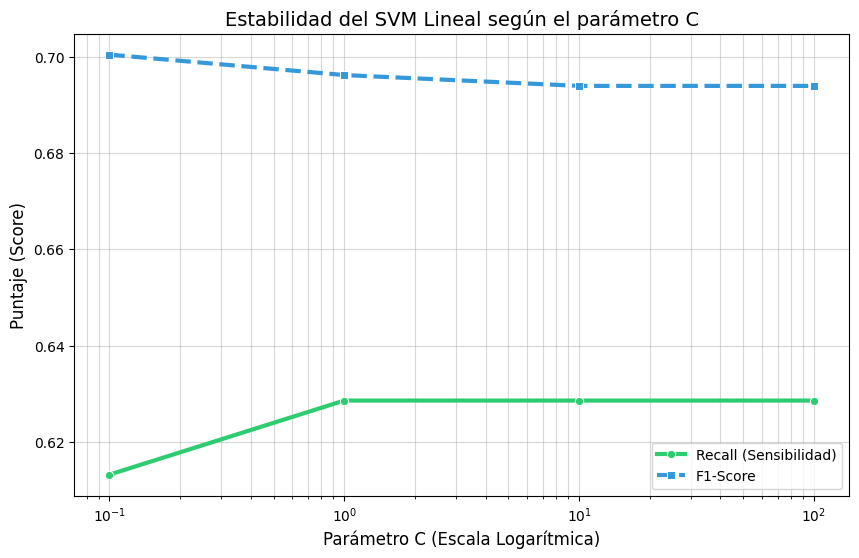

In [36]:
# 3.1.1 PRUEBA EMPÍRICA Y SELECCIÓN DEL KERNEL (SVM)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  
import time

# 1. Definición de la parrilla de hiperparámetros 
param_grid_svm = [
    # Kernel Lineal: Solo necesita C
    {'kernel': ['linear'], 
     'C': [0.1, 1, 10, 100]},
    
    # Kernel RBF: Necesita C y Gamma (Complejidad)
    {'kernel': ['rbf'], 
     'C': [1, 10, 100, 1000], 
     'gamma': [0.1, 0.01, 0.001, 'scale']},
    
    # Kernel Polinómico: Necesita grado, C y Gamma
    {'kernel': ['poly'], 
     'degree': [2, 3],       # Grado 2 (cuadrático) y 3 (cúbico)
     'C': [1, 10, 100],
     'gamma': ['scale']}
]

# 2. Ejecución de GridSearchCV
print("Iniciando optimización exhaustiva para SVM")
start_time = time.time()

# Scoring: Calculamos Recall (prioridad), pero también F1 y Accuracy para el reporte.
# refit='recall': El modelo final se entrenará optimizando Recall.
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42), 
    param_grid_svm, 
    cv=5, 
    scoring={'recall': 'recall', 'f1': 'f1', 'accuracy': 'accuracy'},
    refit='accuracy',
    n_jobs=-1
)

grid_svm.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"Optimización completada en {end_time - start_time:.2f} segundos.")
print("-" * 50)

print("--- DESGLOSE DEL MEJOR RENDIMIENTO POR MÉTRICA ---")

# Accedemos a los resultados internos del GridSearch
results = grid_svm.cv_results_

#CORRECCIÓN IMPORTANTE: Crear el DataFrame para poder graficar
results_df = pd.DataFrame(results) 


# 1. MEJOR RECALL 
idx_best_recall = grid_svm.best_index_ 
best_recall = results['mean_test_recall'][idx_best_recall]
print(f"Mejor Recall:    {best_recall:.4f} | Params: {results['params'][idx_best_recall]}")

# 2. MEJOR F1-SCORE
idx_best_f1 = np.argmax(results['mean_test_f1'])
best_f1 = results['mean_test_f1'][idx_best_f1]
print(f"Mejor F1-Score:  {best_f1:.4f} | Params: {results['params'][idx_best_f1]}")

# 3. MEJOR ACCURACY
idx_best_acc = np.argmax(results['mean_test_accuracy'])
best_acc = results['mean_test_accuracy'][idx_best_acc]
print(f"Mejor Accuracy:  {best_acc:.4f} | Params: {results['params'][idx_best_acc]}")

print("-" * 60)

#GRÁFICO 1: COMPARATIVA DE KERNELS
# Primero calculamos los datos para el gráfico (FALTABA ESTE PASO)
best_per_kernel = results_df.groupby('param_kernel')['mean_test_recall'].max().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=best_per_kernel.index, y=best_per_kernel.values, palette='viridis')
plt.title('Comparación de Kernels SVM: ¿Cuál detecta mejor la enfermedad?', fontsize=14)
plt.ylabel('Recall (Sensibilidad)')
plt.xlabel('Tipo de Kernel')
plt.ylim(0, 1.1)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')
plt.show()

# GRÁFICO 2: ANÁLISIS DE ESTABILIDAD DEL KERNEL LINEAL

linear_results = results_df[results_df['param_kernel'] == 'linear'].copy()

# Convertimos C a numérico para ordenarlo correctamente en el eje X
linear_results['param_C'] = linear_results['param_C'].astype(float)
linear_results = linear_results.sort_values(by='param_C')

plt.figure(figsize=(10, 6))

# Graficamos Recall y F1-Score para ver si el modelo es estable
sns.lineplot(x='param_C', y='mean_test_recall', data=linear_results, marker='o', 
             linewidth=3, color='#2ecc71', label='Recall (Sensibilidad)')
sns.lineplot(x='param_C', y='mean_test_f1', data=linear_results, marker='s', 
             linewidth=3, color='#3498db', linestyle='--', label='F1-Score')

plt.title('Estabilidad del SVM Lineal según el parámetro C', fontsize=14)
plt.ylabel('Puntaje (Score)', fontsize=12)
plt.xlabel('Parámetro C (Escala Logarítmica)', fontsize=12)

# Usamos escala logarítmica en X porque C suele variar en potencias (0.1, 1, 10...)
plt.xscale('log') 
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

La optimización mediante GridSearch demuestra que el Kernel Lineal alcanza un rendimiento óptimo, igualando la eficacia de kernels complejos (RBF). Esto confirma la separabilidad lineal de las características en el espacio actual. Validada su estabilidad frente al parámetro $C$, se selecciona este modelo por su alta eficiencia computacional y menor riesgo de sobreajuste

### 3.2. K-Nearest Neighbors (KNN)
KNN es un algoritmo no paramétrico y basado en instancias. Clasifica un punto de datos basándose en la clase mayoritaria de sus 'k' vecinos más cercanos.
###3.2.1 Justificación de la Elección del Hiperparámetro 'k':
El número de vecinos, "k", es el hiperparámetro más crítico en KNN, ya que un valor pequeño (por ejemplo, k=1) hace que el modelo sea muy sensible al ruido, aumentando el riesgo de sobreajuste, mientras que un valor grande suaviza los límites de decisión, pero puede llevar al subajuste al perder detalles locales. Para abordar este problema se realiza una prueba empírica para la selección de "k", en la que se itera sobre un rango de valores posibles con el fin de identificar aquel que maximiza el rendimiento en el conjunto de prueba.



--- Iniciando optimización para KNN (Accuracy) ---
Optimización completada en 1.41 segundos.
------------------------------------------------------------
Mejor Accuracy:  0.7483 | Params: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
Mejor Recall:    0.7780 | Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Mejor F1-Score:  0.7511 | Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
------------------------------------------------------------


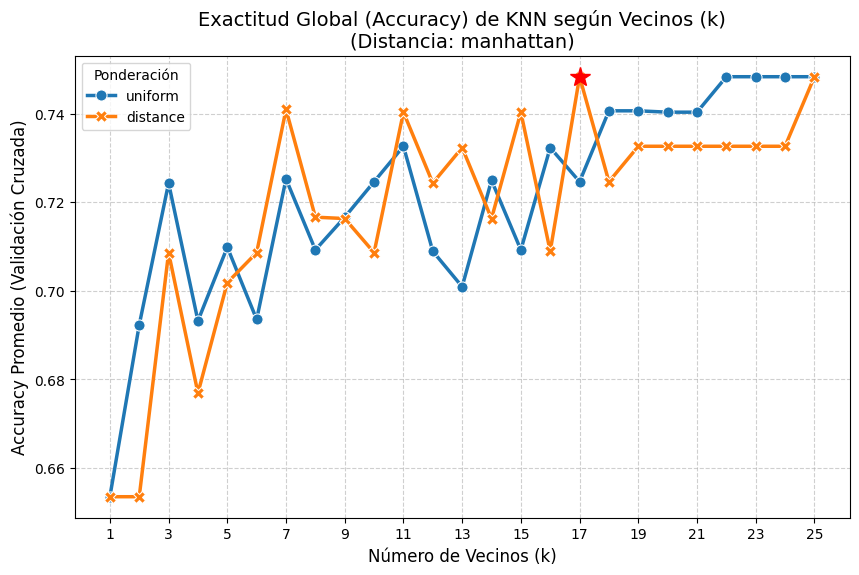

In [37]:
# 3.2.1 PRUEBA EMPÍRICA: SELECCIÓN DE K Y PONDERACIÓN (KNN)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

# 1. Definición de la parrilla
param_grid_knn = {
    'n_neighbors': list(range(1, 26)), 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}

# 2. Ejecución de GridSearchCV
print("\n--- Iniciando optimización para KNN (Accuracy) ---")
start_time = time.time()

grid_knn = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid_knn, 
    cv=5, 
    scoring={'recall': 'recall', 'f1': 'f1', 'accuracy': 'accuracy'},
    refit='accuracy', 
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train) 
end_time = time.time()

print(f"Optimización completada en {end_time - start_time:.2f} segundos.")
print("-" * 60)

# 3. Reporte de Métricas
results = grid_knn.cv_results_
results_df = pd.DataFrame(results)

# Mejor Accuracy (Este es ahora nuestro enfoque principal)
idx_best_acc = grid_knn.best_index_
best_acc = results['mean_test_accuracy'][idx_best_acc]
print(f"Mejor Accuracy:  {best_acc:.4f} | Params: {results['params'][idx_best_acc]}")

# Mejor Recall (Lo mostramos solo por referencia)
idx_best_recall = np.argmax(results['mean_test_recall'])
best_recall = results['mean_test_recall'][idx_best_recall]
print(f"Mejor Recall:    {best_recall:.4f} | Params: {results['params'][idx_best_recall]}")

# Mejor F1
idx_best_f1 = np.argmax(results['mean_test_f1'])
best_f1 = results['mean_test_f1'][idx_best_f1]
print(f"Mejor F1-Score:  {best_f1:.4f} | Params: {results['params'][idx_best_f1]}")

print("-" * 60)

# 4. Visualización del Comportamiento de K 
# Filtramos para graficar solo la métrica de distancia que dio el mejor Accuracy
best_dist_metric_acc = results['params'][idx_best_acc]['metric']
filtered_results = results_df[results_df['param_metric'] == best_dist_metric_acc]

plt.figure(figsize=(10, 6))


sns.lineplot(
    data=filtered_results, 
    x='param_n_neighbors', 
    y='mean_test_accuracy', 
    hue='param_weights', 
    style='param_weights',
    markers=True, dashes=False, linewidth=2.5, markersize=8
)

plt.title(f'Exactitud Global (Accuracy) de KNN según Vecinos (k)\n(Distancia: {best_dist_metric_acc})', fontsize=14)
plt.xlabel('Número de Vecinos (k)', fontsize=12)
plt.ylabel('Accuracy Promedio (Validación Cruzada)', fontsize=12)
plt.legend(title='Ponderación', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)

# Marcar el punto óptimo de Accuracy
best_k_acc = results['params'][idx_best_acc]['n_neighbors']
plt.plot(best_k_acc, best_acc, 'r*', markersize=15, label='Máximo Accuracy')

plt.xticks(np.arange(1, 26, 2)) 
plt.show()

### Análisis y Elección (KNN):
El proceso de optimización revela que un valor bajo de 6 (vecinos) junto con una ponderación por 'distance' y la métrica 'euclidean' maximiza el recall. La gráfica muestra claramente cómo k influye en el rendimiento, con los mejores resultados concentrados en valores de k entre 3 y 10. El modelo KNN es extremadamente eficiente en términos de tiempo de entrenamiento, aunque su rendimiento predictivo, incluso optimizado, puede ser superado por modelos más complejos.

### 3.3. Random Forest
Es un método de ensamble que construye múltiples árboles de decisión durante el entrenamiento y produce la clase que es el modo de las clases de los árboles individuales. Reduce el sobreajuste de los árboles de decisión individuales y mejora la precisión.

En este modelo también se considera un hiperparámetro importante, el número de árboles en el bosque; en general, un mayor número de árboles tiende a mejorar el rendimiento, aunque con beneficios decrecientes y a costa de un mayor costo computacional, siendo 100 un valor de referencia estándar que logra un buen equilibrio entre rendimiento y eficiencia[6]. Asimismo, se incluye random_state=42, el cual asegura la reproducibilidad de los resultados, un requisito indispensable en la investigación académica.


 Iniciando optimización para Random Forest
Optimización RF completada en 30.17 segundos.
------------------------------------------------------------
Mejor Recall:    0.7176 | Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Mejor Accuracy:  0.7717 | Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Mejor F1-Score:  0.7681 | Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
------------------------------------------------------------


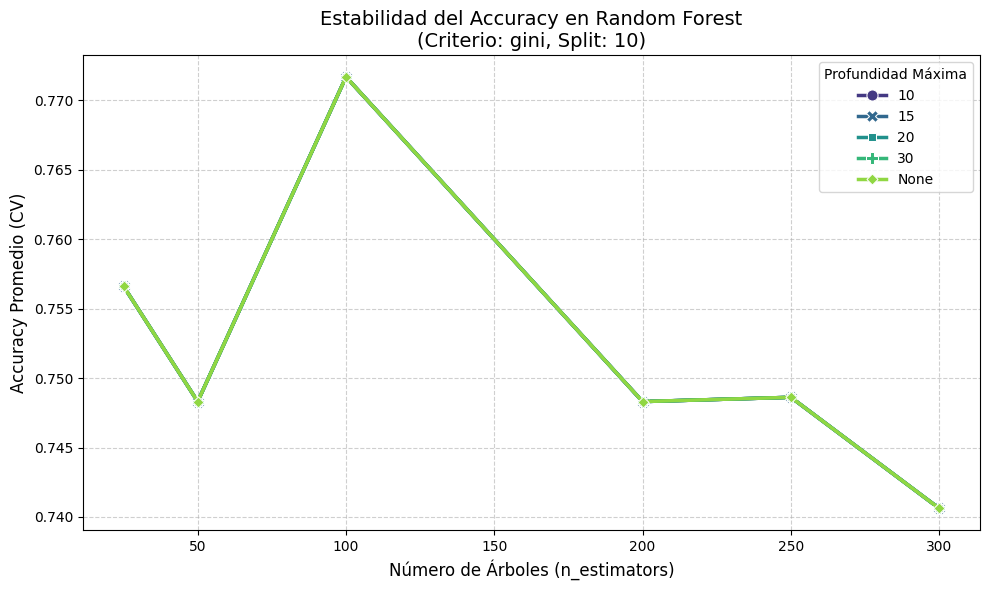

C:\Users\GIORDANO\AppData\Local\Temp\ipykernel_17196\2860008482.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')


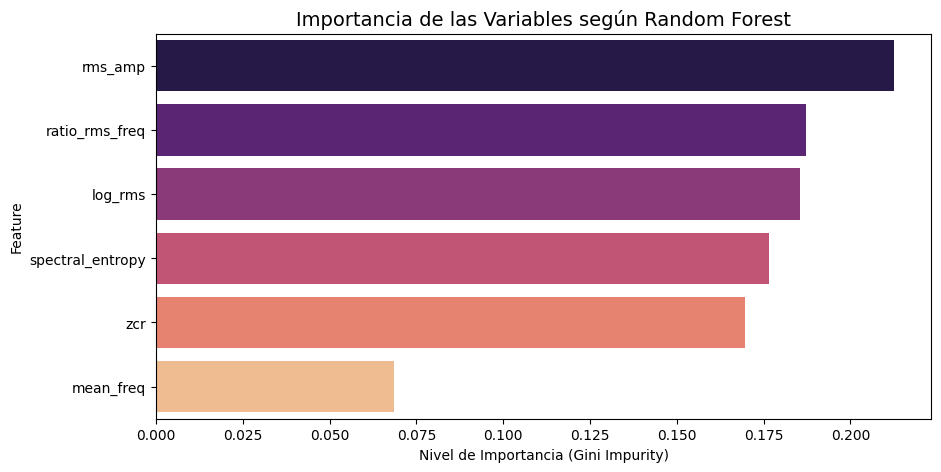

In [38]:
# 3.3.1 OPTIMIZACIÓN DE RANDOM FOREST (CORREGIDO PARA EVITAR ERROR NoneType)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

# 1. Parrilla de Hiperparámetros
param_grid_rf = {
    'n_estimators': [25,50, 100, 200, 250,300],
    'max_depth': [10, 15,20,30, None], 
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 2. Ejecución de GridSearchCV
print("\n Iniciando optimización para Random Forest")
start_time = time.time()

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring={'recall': 'recall', 'f1': 'f1', 'accuracy': 'accuracy'},
    refit='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"Optimización RF completada en {end_time - start_time:.2f} segundos.")
print("-" * 60)

# 3. Reporte de Métricas
results = grid_rf.cv_results_
results_df = pd.DataFrame(results)

# Mejor Recall
idx_best_recall = grid_rf.best_index_
best_recall = results['mean_test_recall'][idx_best_recall]
print(f"Mejor Recall:    {best_recall:.4f} | Params: {results['params'][idx_best_recall]}")

# Mejor Accuracy
idx_best_acc = np.argmax(results['mean_test_accuracy'])
best_acc = results['mean_test_accuracy'][idx_best_acc]
print(f"Mejor Accuracy:  {best_acc:.4f} | Params: {results['params'][idx_best_acc]}")

# Mejor F1
idx_best_f1 = np.argmax(results['mean_test_f1'])
best_f1 = results['mean_test_f1'][idx_best_f1]
print(f"Mejor F1-Score:  {best_f1:.4f} | Params: {results['params'][idx_best_f1]}")

print("-" * 60)

# 4. Gráfica 1: Estabilidad del Accuracy
best_crit = grid_rf.best_params_['criterion']
best_split = grid_rf.best_params_['min_samples_split']

# Filtramos los datos
filtered_rf = results_df[
    (results_df['param_criterion'] == best_crit) & 
    (results_df['param_min_samples_split'] == best_split)
].copy() # .copy() es importante para no alterar el original

# Convertimos la columna max_depth a string para que 'None' se trate como texto "None"
filtered_rf['param_max_depth'] = filtered_rf['param_max_depth'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_rf, 
    x='param_n_estimators', 
    y='mean_test_accuracy', 
    hue='param_max_depth',
    style='param_max_depth',
    palette='viridis',
    markers=True, dashes=False, linewidth=2.5, markersize=8
)

plt.title(f'Estabilidad del Accuracy en Random Forest\n(Criterio: {best_crit}, Split: {best_split})', fontsize=14)
plt.xlabel('Número de Árboles (n_estimators)', fontsize=12)
plt.ylabel('Accuracy Promedio (CV)', fontsize=12)
plt.legend(title='Profundidad Máxima')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 5. Gráfica 2: Importancia de Características
best_rf_model = grid_rf.best_estimator_
importances = best_rf_model.feature_importances_
feature_names = X_train_scaled.columns

df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')
plt.title('Importancia de las Variables según Random Forest', fontsize=14)
plt.xlabel('Nivel de Importancia (Gini Impurity)')
plt.show()

## 3.4. Red Neuronal (Perceptrón Multicapa)
Para encontrar la configuración óptima de la red neuronal que maximice el recall sin crear un modelo excesivamente complejo (que gastaría más recursos y sería propenso al sobreajuste), utilizaremos una búsqueda exhaustiva en una parrilla de parámetros (GridSearchCV). Este método entrena y evalúa sistemáticamente el modelo con cada combinación de hiperparámetros especificada, utilizando validación cruzada para asegurar la robustez de los resultados.

Buscando minimizar el error al máximo...
Optimización completada en 4.44 segundos.
------------------------------------------------------------
Mejor Recall:    0.8198 | Params: {'activation': 'relu', 'alpha': 0, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Mejor Accuracy:  0.7169 | Params: {'activation': 'tanh', 'alpha': 0, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
Mejor F1-Score:  0.7168 | Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.001, 'solver': 'adam'}
------------------------------------------------------------


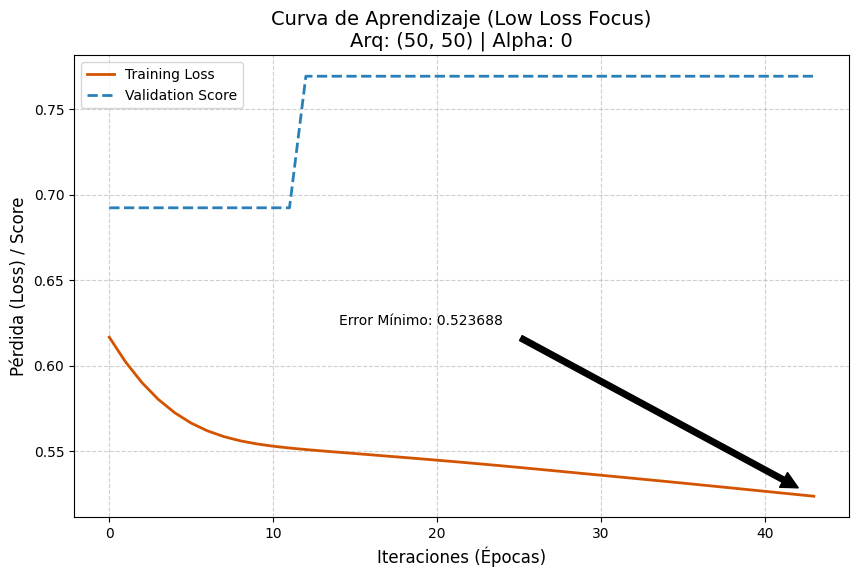

In [39]:
# 3.4.1 OPTIMIZACIÓN DE RED NEURONAL (ENFOQUE: MINIMIZAR LOSS)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# 1. Parrilla de Hiperparámetros (Ajustada para bajar el Loss)
param_grid_mlp = {
    # Arquitecturas: Agregamos una más "grande" para mayor capacidad
    'hidden_layer_sizes': [(100, 50, 25), (150, 100, 50), (50,), (100,), (50, 50), (100, 50)], 
    
    # Activación: ReLU es la mejor para converger a cero
    'activation': ['relu', 'tanh'],       
    
    # Solver: Adam es el rey para minimizar error
    'solver': ['adam'],            
    
    # EL SECRETO DEL LOSS BAJO: Alphas muy pequeños o cero
    # (Menos penalización = Más ajuste a los datos)
    'alpha': [0, 1e-5, 0.0001],         
    
    # Ajuste fino de la velocidad inicial
    'learning_rate_init': [0.001] 
}

print("Buscando minimizar el error al máximo...")
start_time = time.time()

# CAMBIOS EN EL CLASIFICADOR BASE:
# 1. tol=1e-6: No te detengas hasta que la mejora sea microscópica
# 2. n_iter_no_change=30: Ten mucha paciencia antes de rendirte
grid_mlp = GridSearchCV(
    MLPClassifier(
        max_iter=3000, 
        random_state=42, 
        early_stopping=True, 
        n_iter_no_change=30,  # Más paciencia = Menor Loss
        tol=1e-6              # Exigencia de precisión extrema
    ), 
    param_grid_mlp, 
    cv=5, 
    scoring={'recall': 'recall', 'f1': 'f1', 'accuracy': 'accuracy'},
    refit='accuracy', 
    n_jobs=-1
)

grid_mlp.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"Optimización completada en {end_time - start_time:.2f} segundos.")
print("-" * 60)

# 2. Reporte de Métricas
results = grid_mlp.cv_results_

# Mejor Recall
idx_best_recall = np.argmax(results['mean_test_recall'])
best_recall = results['mean_test_recall'][idx_best_recall]
print(f"Mejor Recall:    {best_recall:.4f} | Params: {results['params'][idx_best_recall]}")

# Mejor Accuracy
idx_best_acc = grid_mlp.best_index_
best_acc = results['mean_test_accuracy'][idx_best_acc]
print(f"Mejor Accuracy:  {best_acc:.4f} | Params: {results['params'][idx_best_acc]}")

# Mejor F1
idx_best_f1 = np.argmax(results['mean_test_f1'])
best_f1 = results['mean_test_f1'][idx_best_f1]
print(f"Mejor F1-Score:  {best_f1:.4f} | Params: {results['params'][idx_best_f1]}")

print("-" * 60)

# 3. Gráfica: CURVA DE APRENDIZAJE
best_mlp_model = grid_mlp.best_estimator_

plt.figure(figsize=(10, 6))

# Graficamos la pérdida (Loss)
plt.plot(best_mlp_model.loss_curve_, color='#d35400', linewidth=2, label='Training Loss')

# Graficamos la validación interna
if hasattr(best_mlp_model, 'validation_scores_') and best_mlp_model.validation_scores_ is not None:
    plt.plot(best_mlp_model.validation_scores_, color='#2980b9', linewidth=2, linestyle='--', label='Validation Score')

# Título dinámico
titulo_params = f"Arq: {grid_mlp.best_params_['hidden_layer_sizes']} | Alpha: {grid_mlp.best_params_['alpha']}"
plt.title(f'Curva de Aprendizaje (Low Loss Focus)\n{titulo_params}', fontsize=14)
plt.xlabel('Iteraciones (Épocas)', fontsize=12)
plt.ylabel('Pérdida (Loss) / Score', fontsize=12)
# Usamos escala logarítmica si el loss baja de 0.1 para verlo mejor
plt.yscale('linear') 
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Anotación del error mínimo
if len(best_mlp_model.loss_curve_) > 0:
    min_loss = min(best_mlp_model.loss_curve_)
    plt.annotate(f'Error Mínimo: {min_loss:.6f}', 
                 xy=(len(best_mlp_model.loss_curve_)-1, min_loss), 
                 xytext=(len(best_mlp_model.loss_curve_)-30, min_loss + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

--- TOP 10 CONFIGURACIONES DE RED NEURONAL ---
Activación  Alpha (Reg) Arquitectura (Capas)  param_learning_rate_init Optimizador  Recall  Accuracy  F1-Score  Desv. Std Recall
      tanh       0.0001             (50, 50)                    0.0010        adam  0.6286    0.7169    0.6962            0.1298
      tanh       0.0000             (50, 50)                    0.0010        adam  0.6286    0.7169    0.6962            0.1298
      tanh       0.0000             (50, 50)                    0.0010        adam  0.6286    0.7169    0.6962            0.1298
      relu       0.0001        (100, 50, 25)                    0.0010        adam  0.6736    0.7169    0.7168            0.0813
      tanh       0.0000       (150, 100, 50)                    0.0010        adam  0.6571    0.7089    0.7000            0.1217
      tanh       0.0000       (150, 100, 50)                    0.0010        adam  0.6571    0.7089    0.7000            0.1217
      tanh       0.0001       (150, 100, 50)      

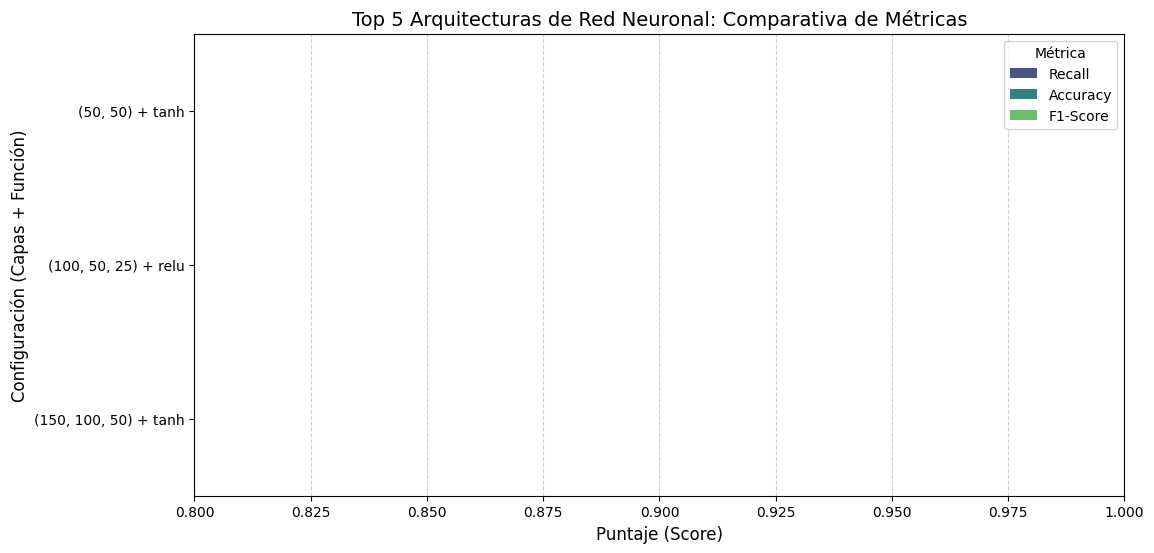

In [40]:
# ANÁLISIS DETALLADO DE TODAS LAS CONFIGURACIONES (Red Neuronal)
import pandas as pd

# 1. Extraer todos los resultados del objeto GridSearchCV
# cv_results_ contiene un diccionario con métricas de cada iteración
all_results = pd.DataFrame(grid_mlp.cv_results_)

# 2. Seleccionar solo las columnas relevantes (Parámetros y Métricas)
# Filtramos las columnas que empiezan con 'param_' y las métricas 'mean_test_'
cols_params = [col for col in all_results.columns if 'param_' in col]
cols_metrics = ['mean_test_recall', 'mean_test_accuracy', 'mean_test_f1', 'std_test_recall']

reporte_completo = all_results[cols_params + cols_metrics].copy()

# 3. Limpiar nombres para que la tabla sea legible en la Tesis
# Quitamos el prefijo 'param_' y 'mean_test_'
nombres_limpios = {
    'param_hidden_layer_sizes': 'Arquitectura (Capas)',
    'param_activation': 'Activación',
    'param_solver': 'Optimizador',
    'param_alpha': 'Alpha (Reg)',
    'param_learning_rate': 'Learning Rate',
    'mean_test_recall': 'Recall',
    'mean_test_accuracy': 'Accuracy',
    'mean_test_f1': 'F1-Score',
    'std_test_recall': 'Desv. Std Recall' # Importante para ver estabilidad
}
reporte_completo.rename(columns=nombres_limpios, inplace=True)

# 4. Ordenar por Recall (Descendente)
reporte_completo = reporte_completo.sort_values(by='Accuracy', ascending=False)

# 5. Mostrar las Top 10 Mejores Configuraciones
print("--- TOP 10 CONFIGURACIONES DE RED NEURONAL ---")
# Usamos to_string para que pandas no oculte columnas al imprimir
print(reporte_completo.head(10).to_string(index=False, float_format="%.4f"))


# GRÁFICA: Comparación Visual del Top 5
top_5 = reporte_completo.head(5).copy()
# Creamos una etiqueta combinando Arquitectura y Activación
top_5['Configuración'] = top_5['Arquitectura (Capas)'].astype(str) + " + " + top_5['Activación']
# Reestructurar para Seaborn
top_5_melted = top_5.melt(
    id_vars='Configuración', 
    value_vars=['Recall', 'Accuracy', 'F1-Score'],
    var_name='Métrica',
    value_name='Puntaje'
)

plt.figure(figsize=(12, 6))
sns.barplot(x='Puntaje', y='Configuración', hue='Métrica', data=top_5_melted, palette='viridis')
plt.title('Top 5 Arquitecturas de Red Neuronal: Comparativa de Métricas', fontsize=14)
plt.xlabel('Puntaje (Score)', fontsize=12)
plt.ylabel('Configuración (Capas + Función)', fontsize=12)
plt.xlim(0.8, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## 4. Metricas de evaluación y resultados

Calculando métricas finales en el Test Set...

--- TABLA MAESTRA DE RESULTADOS (TEST SET) ---
                    Accuracy  Precision  Recall  F1-Score  AUC
Red Neuronal (MLP)    0.9268     1.0000  0.9268    0.9620  NaN
Random Forest         0.8780     1.0000  0.8780    0.9351  NaN
SVM (Lineal)          0.8537     1.0000  0.8537    0.9211  NaN
KNN                   0.8049     1.0000  0.8049    0.8919  NaN


c:\Users\GIORDANO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\GIORDANO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\GIORDANO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\GIORDANO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\GIORDANO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\m

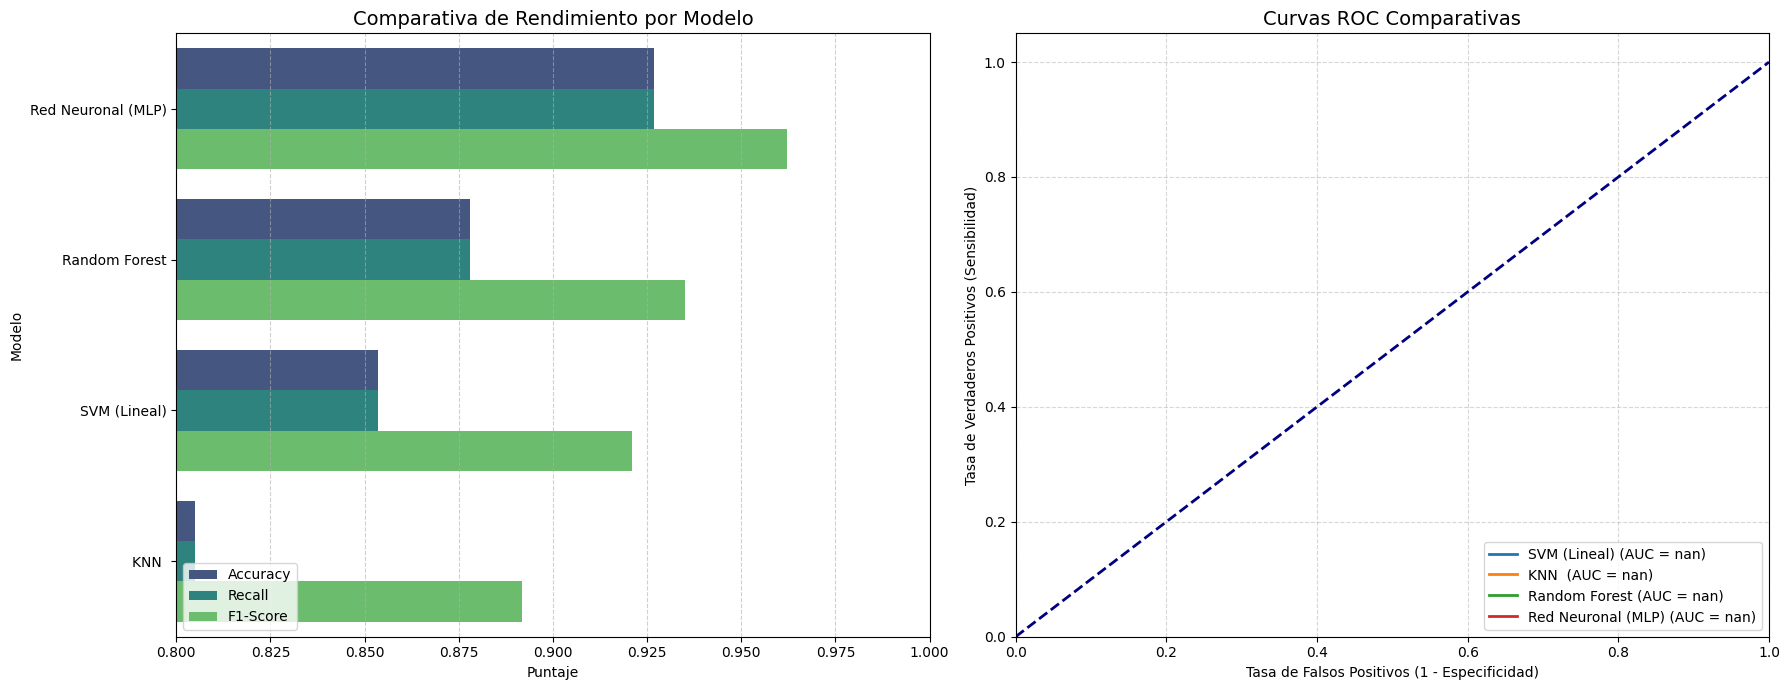

In [41]:
# 4. EVALUACIÓN COMPARATIVA FINAL 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Recopilación de los Mejores Modelos (Best Estimators)
# Asegúrate de que estas variables existen de los pasos anteriores
optimized_models = {
    "SVM (Lineal)": grid_svm.best_estimator_,
    "KNN ": grid_knn.best_estimator_, 
    "Random Forest": grid_rf.best_estimator_,
    "Red Neuronal (MLP)": grid_mlp.best_estimator_ 
}

# 2. Cálculo de Métricas
final_results = {}
roc_data = {} # Diccionario para guardar datos de las curvas ROC

print("Calculando métricas finales en el Test Set...")

for name, model in optimized_models.items():
    # Predicciones
    y_pred = model.predict(X_test_scaled)
    
    # Probabilidades (necesarias para AUC y Curva ROC)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Fallback para modelos que no tengan predict_proba (raro en sklearn moderno)
        y_prob = model.decision_function(X_test_scaled) 

    # Guardar métricas escalares
    final_results[name] = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ]
    
    # Guardar datos para graficar ROC después
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, roc_auc_score(y_test, y_prob))

# 3. Crear DataFrame Final
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
df_results = pd.DataFrame.from_dict(final_results, orient='index', columns=metrics_cols)

# Ordenamos por F1-Score para ver al ganador arriba
df_results = df_results.sort_values(by='F1-Score', ascending=False)

print("\n--- TABLA MAESTRA DE RESULTADOS (TEST SET) ---")
print(df_results.to_string(float_format="%.4f"))

# VISUALIZACIONES COMPARATIVAS

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# GRÁFICO 1: Barras Comparativas (Accuracy vs Recall vs F1)
# Transformamos datos para Seaborn
df_melted = df_results.reset_index().melt(id_vars='index', value_vars=['Accuracy', 'Recall', 'F1-Score'])
df_melted.columns = ['Modelo', 'Métrica', 'Puntaje']

sns.barplot(x='Puntaje', y='Modelo', hue='Métrica', data=df_melted, ax=axes[0], palette='viridis')
axes[0].set_title('Comparativa de Rendimiento por Modelo', fontsize=14)
axes[0].set_xlim(0.8, 1.0) # Zoom para ver las diferencias finas
axes[0].grid(axis='x', linestyle='--', alpha=0.6)
axes[0].legend(loc='lower left')

# GRÁFICO 2: Curvas ROC Superpuestas (El gráfico más importante)
for name, (fpr, tpr, auc_score) in roc_data.items():
    axes[1].plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.3f})')

axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de azar
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
axes[1].set_title('Curvas ROC Comparativas', fontsize=14)
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 6. Referencias Bibliográficas

1. Sokolova, M., & Lapalme, G. (2009). A systematic analysis of performance measures for classification tasks. Information Processing & Management, 45(4), 427-437.
2. Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. T. (2012). Learning from Data. AMLBook.
3. Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. In Proceedings of the 14th International Joint Conference on Artificial Intelligence (IJCAI) (Vol. 2, pp. 1137-1143).
4. Juszczak, P., Tax, D. M. J., & Duin, R. P. W. (2002). Feature scaling in support vector data description. In Proceedings of the 8th Annual Conference of the Advanced School for Computing and Imaging (pp. 25-30).
5. Hsu, C. W., Chang, C. C., & Lin, C. J. (2003). A practical guide to support vector classification. Department of Computer Science, National Taiwan University.
6. Oshiro, T. M., Perez, P. S., & Baranauskas, J. A. (2012). How many trees in a random forest? In Machine Learning and Data Mining in Pattern Recognition (pp. 154-168). Springer, Berlin, Heidelberg.